# Data profiling

In [2]:
import pandas as pd
import numpy as np
from support_functions import log_progress, clean_drugbank, query_chembl
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import functools
from cmapPy.pandasGEXpress import parse
import scipy
%load_ext line_profiler
import time

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## 0. Lookup known targets

In [77]:
# load perturbation info
pert_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
pert_info_2a = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
all_pert_info = pd.concat([pert_info_1, pert_info_2a], ignore_index=True)

In [78]:
# lookup cpd inchi keys
all_cpd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_cp']
all_cpd_inchis = all_cpd_pert_info[['pert_id','inchi_key']].set_index('pert_id').copy()
# remove duplicates, store as series
all_cpd_inchis = all_cpd_inchis[~all_cpd_inchis.index.duplicated()].inchi_key

### 0a. Lookup Drugbank targets

In [5]:
# lookup and store drugbank targets as dictionary: { inchi: [targets]}
db_db_path = 'data/full_drugbank_database.xml'
drugbank_target_dict = clean_drugbank(db_db_path)

KeyboardInterrupt: 

In [ ]:
# save to file
filename = 'checkpoint_files/drugbank_target_dict.sav'
pickle.dump(drugbank_target_dict, open(filename, 'wb'))

### 0b. Lookup Chembl targets

In [ ]:
# lookup and store chembl targets as dictionary: { inchi: [targets]}
chembl_target_dict = {}
tested_inchis = [] # b/c this bitch keeps crashing

In [ ]:
# query CHEMBL API using cpd inchi_keys to find human targets
for inchi in log_progress(all_cpd_inchis.values, every=2):
    if inchi not in tested_inchis:
        human_target_genes = query_chembl(inchi)
        if len(human_target_genes) > 0:
            chembl_target_dict[inchi] = human_target_genes
        tested_inchis.append(inchi)

In [ ]:
# save to file
filename = 'checkpoint_files/chembl_target_dict.sav'
pickle.dump(chembl_target_dict, open(filename, 'wb'))

### 0c. Combine targets

In [79]:
drugbank_target_dict = pickle.load(open('checkpoint_files/drugbank_target_dict.sav', 'rb'))
chembl_target_dict = pickle.load(open('checkpoint_files/chembl_target_dict.sav', 'rb'))

combined_target_dict = drugbank_target_dict.copy()
for cpd, chembl_targets in log_progress(chembl_target_dict.items()):
    try:
        drugbank_targets = drugbank_target_dict[cpd]
        combined_targets = list(set().union(chembl_targets,drugbank_targets))
        combined_target_dict[cpd] = combined_targets
    except KeyError:
        combined_target_dict[cpd] = chembl_targets

## 1. Identify cpd-KD pairs (pair set 1)

The first of several filtering steps, this set is composed of pairs of known cpd-target interactions where both the cpd and the target KD have been tested in at least one LINCS experiment.

In [80]:
all_kd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_sh']
kd_genes = all_kd_pert_info.pert_iname.unique()
len(kd_genes)

4371

In [83]:
cpd_1_, target_1_, label_1_ = [], [], []
for index, row in log_progress(all_cpd_pert_info.iterrows(), every=1000):
    inchi = row.inchi_key
    
    # if the cpd has targets
    if inchi in combined_target_dict.keys():
        pert_id = row.pert_id
        targets = combined_target_dict[inchi]
        
        # add targets as positive examples
        for target in targets:
            if target in kd_genes:
                cpd_1_.append(pert_id)
                target_1_.append(target)
                label_1_.append(1)
                
        # add non-targets as negative examples
        for gene in kd_genes:
            if gene not in targets:
                cpd_1_.append(pert_id)
                target_1_.append(gene)
                label_1_.append(0)
                
    # if the compound has no targets
    else:
        pert_id = row.pert_id
        for gene in kd_genes:
            cpd_1_.append(pert_id)
            target_1_.append(gene)
            label_1_.append(0)

In [84]:
pair_set_1_df = pd.DataFrame({'cpd': cpd_1_, 'target': target_1_, 'label': label_1_})
pair_set_1_df.to_csv('checkpoint_files/pair_set_1_df.csv')

In [85]:
pair_set_1_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_1_df.csv')

print('Pair set 1 statistics\n')
print('No. True interactions:\t', pair_set_1_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_1_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_1_df[pair_set_1_df.label == 0].target.unique()))

Pair set 1 statistics

No. True interactions:	 4220
No. True cpds:		 1076
No. True genes:		 624

No. False interactions:	 97071332
No. False cpds:		 21299
No. False genes:	 4371


## 2. Identify same-cell cpd-KD pairs (pair set 2)

The second of several filtering steps, here we filter out cpd-KD pairs that have not both been tested in at least one common cell line.

### 2a. Signature quality filter

This step of finding common cells for all 100 million potential cpd-kd pairs is very slow. To speed things up we'll apply the signature quality filter here, rather than later on in the pipeline. We'll also store the high-quality signatures in dictionaries so that we can look them up quickly.

In [8]:
# load the signature information
all_sig_info = pd.DataFrame.from_csv('checkpoint_files/all_sig_info.csv')
all_cpd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_cp'].copy()
all_kd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_sh'].copy()

/Users/Nico/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [12]:
# data quality parameters 
pct_self_rank_cutoff = 0.05
distill_cc_cutoff = 0.2

# filter the data
good_cpd_sig_info = all_cpd_sig_info[(all_cpd_sig_info.distil_cc_q75 >= distill_cc_cutoff) &
                                     (all_cpd_sig_info.pct_self_rank_q25 <= pct_self_rank_cutoff)].copy()
good_kd_sig_info = all_kd_sig_info[(all_kd_sig_info.distil_cc_q75 >= distill_cc_cutoff) &
                                   (all_kd_sig_info.pct_self_rank_q25 <= pct_self_rank_cutoff)].copy()

In [13]:
# create a dictionary of the good signatures so we can 
# look them up quickly by cpd/kd
good_cpds = set(good_cpd_sig_info.pert_id.unique())
good_cpd_sig_info_dict = {}
for cpd in log_progress(good_cpds):
    good_cpd_sig_info_dict[cpd] = good_cpd_sig_info[good_cpd_sig_info.pert_id == cpd].copy()
    
good_kds = set(good_kd_sig_info.pert_iname.unique())
good_kd_sig_info_dict = {}
for kd in log_progress(good_kds):
    good_kd_sig_info_dict[kd] = good_kd_sig_info[good_kd_sig_info.pert_iname == kd].copy()

In [14]:
# select representative sigs for good cpds
repr_cpd_sig_info_dict = {}
for cpd, good_sig_df in log_progress(good_cpd_sig_info_dict.items()):
    repr_cpd_sigs_df = pd.DataFrame(columns=good_sig_df.columns)
    for cell_line in good_sig_df.cell_id.unique():
        candidate_sigs = good_sig_df[good_sig_df.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_cpd_sigs_df = repr_cpd_sigs_df.append(repr_sig)
    repr_cpd_sig_info_dict[cpd] = repr_cpd_sigs_df

# select representative kd sigs for good kds
repr_kd_sig_info_dict = {}
for kd, good_sig_df in log_progress(good_kd_sig_info_dict.items()):
    repr_kd_sigs_df = pd.DataFrame(columns=good_sig_df.columns)
    for cell_line in good_sig_df.cell_id.unique():
        candidate_sigs = good_sig_df[good_sig_df.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_kd_sigs_df = repr_kd_sigs_df.append(repr_sig)
    repr_kd_sig_info_dict[kd] = repr_kd_sigs_df

In [15]:
# save the data
pickle.dump(good_cpds, open('checkpoint_files/good_cpds.sav', 'wb'))
pickle.dump(good_kds, open('checkpoint_files/good_kds.sav', 'wb'))
pickle.dump(repr_cpd_sig_info_dict, open('checkpoint_files/repr_cpd_sig_info_dict.sav', 'wb'))
pickle.dump(repr_kd_sig_info_dict, open('checkpoint_files/repr_kd_sig_info_dict.sav', 'wb'))

In [112]:
# load the data
good_cpds = pickle.load(open('checkpoint_files/good_cpds.sav', 'rb'))
good_kds = pickle.load(open('checkpoint_files/good_kds.sav', 'rb'))
repr_cpd_sig_info_dict = pickle.load(open('checkpoint_files/repr_cpd_sig_info_dict.sav', 'rb'))
repr_kd_sig_info_dict = pickle.load(open('checkpoint_files/repr_kd_sig_info_dict.sav', 'rb'))

### 2b. Identify pairs w/ high quality sigs (both cpd and kd)

In [92]:
cpd_2_, target_2_, label_2_, common_cells_2_ = [], [], [], []

for index, row in log_progress(pair_set_1_df.iterrows(), every=5000):

    # bookmark to (hopfeully) save time
    curr_cpd = ''
    curr_cpd_sigs_df = ''
    curr_cpd_cells = ''
    
    # extract signatures
    cpd = row.cpd
    if cpd in good_cpds:
        target = row.target
        if target in good_kds: 
            
            # check if we need to load data for new cpd
            if not cpd == curr_cpd:
                curr_cpd = cpd
                curr_cpd_sigs_df = repr_cpd_sig_info_dict[curr_cpd]
                curr_cpd_cells = set(curr_cpd_sigs_df.cell_id.unique())
            
            # load data for target
            kd_sigs = repr_kd_sig_info_dict[target]
            kd_cells = set(kd_sigs.cell_id.unique())
            
            # compare cell lines
            common_cells = curr_cpd_cells & kd_cells
            if len(common_cells) > 0:
                cpd_2_.append(cpd)
                target_2_.append(target)
                label_2_.append(row.label)
                common_cells_2_.append(common_cells)

In [93]:
pair_set_2_df = pd.DataFrame({'cpd': cpd_2_, 'target': target_2_, 'label': label_2_})
pair_set_2_df.to_csv('checkpoint_files/pair_set_2_df.csv')
pickle.dump(common_cells_2_, open('checkpoint_files/common_cells_2_.sav', 'wb'))

In [4]:
pair_set_2_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_2_df.csv')
common_cells_2_ = pickle.load(open('checkpoint_files/common_cells_2_.sav', 'rb'))

In [5]:
print('Pair set 2 statistics\n')
print('No. True interactions:\t', pair_set_2_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_2_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_2_df[pair_set_2_df.label == 0].target.unique()))

Pair set 2 statistics

No. True interactions:	 2827
No. True cpds:		 636
No. True genes:		 469

No. False interactions:	 18171209
No. False cpds:		 4240
No. False genes:	 4344


## 3. Identify cpd-KD pairs with interaction partner KDs (pair set 3)

The third of several filtering steps, here we filter out cpd-KD pairs for which we do not know any interaction partners for the target.

In [6]:
# load STRING 4.0 database
# 355319.0 high confidence interactions for 14893 genes
string_gene_interactions_700 = pd.DataFrame.from_csv('checkpoint_files/string_gene_interactions_700.csv')
string_genes = set(string_gene_interactions_700.gene_1.unique())

In [10]:
# convert string interactions to dictionary of sets for fast lookup
string_interactions_dict = {}
for gene in log_progress(string_genes, every=10):
    partners = string_gene_interactions_700[string_gene_interactions_700.gene_1 == gene].gene_2
    partner_set = set(partners)
    string_interactions_dict[gene] = partner_set

In [11]:
# save the interactions
pickle.dump(string_interactions_dict, open('checkpoint_files/string_interactions_dict.sav', 'wb'))

In [4]:
# load the interactions
string_interactions_dict = pickle.load(open('checkpoint_files/string_interactions_dict.sav', 'rb'))

In [14]:
cpd_3_, target_3_, label_3_, common_cells_3_ = [], [], [], []
targets_without_partner_kds = []

for index, row in log_progress(pair_set_2_df.iterrows(), every=5000):
    target = row.target
    # check if there are interaction partners
    if target in string_genes:
        partners = string_interactions_dict[target]
        # check if partners have KDS
        partner_kds = partners.intersection(good_kds)   
        if len(partner_kds) > 0:
            cpd_3_.append(row.cpd)
            target_3_.append(target)
            label_3_.append(row.label)
            common_cells_3_.append(common_cells_2_[index])
        else:
            targets_without_partner_kds.append(target)

In [15]:
pair_set_3_df = pd.DataFrame({'cpd': cpd_3_, 'target': target_3_, 'label': label_3_})
pair_set_3_df.to_csv('checkpoint_files/pair_set_3_df.csv')
pickle.dump(common_cells_3_, open('checkpoint_files/common_cells_3_.sav', 'wb'))

In [129]:
pair_set_3_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_3_df.csv')
common_cells_3_ = pickle.load(open('checkpoint_files/common_cells_3_.sav', 'rb'))

In [16]:
print('Pair set 3 statistics\n')
print('No. True interactions:\t', pair_set_3_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_3_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_3_df[pair_set_3_df.label == 0].target.unique()))

Pair set 3 statistics

No. True interactions:	 2789
No. True cpds:		 634
No. True genes:		 455

No. False interactions:	 15528727
No. False cpds:		 4240
No. False genes:	 3668


# 4. Discard pairs not tested in at least 3 different cell lines. (pair set 4)

In [14]:
min_num_cells = 3

In [17]:
cpd_4_, target_4_, label_4_, common_cells_4_ = [], [], [], [],

for index, row in log_progress(pair_set_3_df.iterrows(), every=5000):
    common_cells = common_cells_3_[index]
    if len(common_cells) >= min_num_cells:
        cpd_4_.append(row.cpd)
        target_4_.append(row.target)
        label_4_.append(row.label)
        common_cells_4_.append(common_cells)

In [18]:
pair_set_4_df = pd.DataFrame({'cpd': cpd_4_, 'target': target_4_, 'label': label_4_})

In [19]:
pair_set_4_df.to_csv('checkpoint_files/pair_set_4_df.csv')
pickle.dump(common_cells_4_, open('checkpoint_files/common_cells_4_.sav', 'wb'))

In [4]:
pair_set_4_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_4_df.csv')
common_cells_4_ = pickle.load(open('checkpoint_files/common_cells_4_.sav', 'rb'))

In [20]:
print('Pair set 4 statistics\n')
print('No. True interactions:\t', pair_set_4_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_4_df[pair_set_4_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_4_df[pair_set_4_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_4_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_4_df[pair_set_4_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_4_df[pair_set_4_df.label == 0].target.unique()))

Pair set 4 statistics

No. True interactions:	 1310
No. True cpds:		 232
No. True genes:		 303

No. False interactions:	 4498567
No. False cpds:		 1228
No. False genes:	 3320


## 5. Identify cpd-KD pairs with same-cell interaction partner KDs (pair set 5)

The fourth of several filtering steps, here we filter out cpd-KD pairs for which the target's interaction partners were not knocked down in any of the same cells as the cpd-target pair.

Because this step takes SO long we're going to break up our dataframe into chunks and then run run the filter in parallel.

In [11]:
import multiprocessing
num_processes = 6 #multiprocessing.cpu_count()

In [12]:
def filter_pairs(input_stuff):
    pair_df, common_cells_ = input_stuff
    cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_ = [], [], [], [], []
    
    for index, row in pair_df.iterrows(): 
        
        if index % 10000 == 0: print(index)
        
        common_cells = common_cells_[index]
        target = row.target
        common_partners_dict = {}

        # find interaction partner signatures
        partners = string_interactions_dict[target]
        partner_kds = partners.intersection(good_kds)
        partner_sigs = pd.concat([ repr_kd_sig_info_dict[p] for p in partner_kds ], ignore_index=True)
        # group partner sigs by cell line
        for cell_line in common_cells:
            partner_cell_sigs = partner_sigs[partner_sigs.cell_id == cell_line]
            
            if not partner_cell_sigs.empty:
                cell_partners = set(partner_cell_sigs.pert_iname.unique())
                common_partners_dict[cell_line] = cell_partners

        # make sure we have partner KDs in at least three cell lines,
        # since we're only considering pairs with this minimum amount of data
        if len(common_partners_dict.keys()) >= min_num_cells:
            common_cells_5 = set(common_partners_dict.keys())
            cpd_5_.append(row.cpd)
            target_5_.append(target)
            label_5_.append(row.label)
            common_cells_5_.append(common_cells_5)
            common_partners_5_.append(common_partners_dict)
            
    return cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_

In [13]:
# break the pairs up into batches
num_batches = 10
batch_size = 450000 # len(pair_set_4_df) / num_batches = 449987.7
pdf4_batches = [ pair_set_4_df.iloc[pair_set_4_df.index[i:i + batch_size]].reset_index(drop=True)for i in range(0,num_batches*batch_size,batch_size) ]
common_cell_batches = [ common_cells_4_[i:i + batch_size] for i in range(0,num_batches*batch_size,batch_size) ]

In [14]:
# run the filter on each batch of the data
for j in range(10):
    
    print('STARTING BATCH: ', j)
    # reset memory
    cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_, pair_set_5_df = [None]*6
    result = None
    cpd_5_t, target_5_t, label_5_t, common_cells_5_t, common_partners_5_t = [None]*5

    # get data
    pdf4_batch = pdf4_batches[j]
    cc_batch = common_cell_batches[j]

    # calculate the chunk size as an integer
    chunk_size = int(pdf4_batch.shape[0]/num_processes)

    # break the dataframe up into chunks
    pair_chunks = [ pdf4_batch.iloc[pdf4_batch.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pdf4_batch.shape[0], chunk_size)]
    cell_chunks = [ cc_batch[i:i + chunk_size] for i in range(0, len(cc_batch), chunk_size) ]
    chunks = list(zip(pair_chunks, cell_chunks))

    # filter each section of the pairs dataframe in parallel
    cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_ = [], [], [], [], []
    pool = multiprocessing.Pool(processes=num_processes)
    result = pool.map(filter_pairs, chunks)
    pool.close()

    cpd_5_t, target_5_t, label_5_t, common_cells_5_t, common_partners_5_t = zip(*result)
    cpd_5_ = functools.reduce( lambda x,y: x+y, [ c for c in list(cpd_5_t) ] )
    target_5_ = functools.reduce( lambda x,y: x+y, [ t for t in list(target_5_t) ] )
    label_5_ = functools.reduce( lambda x,y: x+y, [ l for l in list(label_5_t) ] )
    common_cells_5_ = functools.reduce( lambda x,y: x+y, [ cc for cc in list(common_cells_5_t) ] )
    common_partners_5_ = functools.reduce( lambda x,y: x+y, [ cc for cc in list(common_partners_5_t) ] )

    print('\nMAKING DATAFRAME')
    pair_set_5_df = pd.DataFrame({'cpd': cpd_5_, 'target': target_5_, 'label': label_5_})

    print('\nSAVING DATAFRAME')
    df_filename = 'checkpoint_files/pair_set_5_df_{}.csv'.format(j)
    pair_set_5_df.to_csv(df_filename)

    print('\nSAVING COMMON CELLS')
    cc_filename = 'checkpoint_files/common_cells_5_{}.sav'.format(j)
    cc_file = open(cc_filename, 'wb')
    pickle.dump(common_cells_5_, cc_file)
    cc_file.close()

    print('\nSAVING COMMON PARTNERS')
    cp_filename = 'checkpoint_files/common_partners_5_{}.sav'.format(j)
    cp_file = open(cp_filename, 'wb')
    pickle.dump(common_partners_5_, cp_file)
    cp_file.close()

    print('\nDONE')

STARTING BATCH:  0
0
0
0
0
0
0
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
50000
50000
50000
50000
50000
50000
60000
60000
60000
60000
60000
60000
70000
70000
70000
70000
70000
70000

MAKING DATAFRAME

SAVING DATAFRAME

SAVING COMMON CELLS

SAVING COMMON PARTNERS

DONE
STARTING BATCH:  1
0
0
0
0
0
0
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
50000
50000
50000
50000
50000
50000
60000
60000
60000
60000
60000
60000
70000
70000
70000
70000
70000
70000

MAKING DATAFRAME

SAVING DATAFRAME

SAVING COMMON CELLS

SAVING COMMON PARTNERS

DONE
STARTING BATCH:  2
0
0
0
0
0
0
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
50000
50000
50000
50000
50000
50000
60000
60000
60000
60000
60000
60000
70000
70000
7

In [15]:
# LOAD DATA AND put the pieces back together
pair_set_5_df = pd.DataFrame(columns=pair_set_4_df.columns)
common_cells_5_ = []
common_partners_5_ = []

for j in log_progress(range(10)):
    df_filename = 'checkpoint_files/pair_set_5_df_{}.csv'.format(j)
    cc_filename = 'checkpoint_files/common_cells_5_{}.sav'.format(j)
    cp_filename = 'checkpoint_files/common_partners_5_{}.sav'.format(j)
    
    pair_set_5_df = pair_set_5_df.append(pd.DataFrame.from_csv(df_filename))
    common_cells_5_ += pickle.load(open(cc_filename, 'rb'))
    #common_partners_5_ += pickle.load(open(cp_filename, 'rb'))

In [8]:
print('Pair set 5 statistics\n')
print('No. True interactions:\t', pair_set_5_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_5_df[pair_set_5_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_5_df[pair_set_5_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_5_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_5_df[pair_set_5_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_5_df[pair_set_5_df.label == 0].target.unique()))

Pair set 5 statistics

No. True interactions:	 1308
No. True cpds:		 232
No. True genes:		 302

No. False interactions:	 4429884
No. False cpds:		 1228
No. False genes:	 3288


## Cell count anaylsis
Which cell lines are are true interactions happening in?

In [16]:
true_pair_idx = pair_set_5_df[pair_set_5_df.label == 1].index.values.astype(int)
true_pair_common_cells = np.array(common_cells_5_)[true_pair_idx]

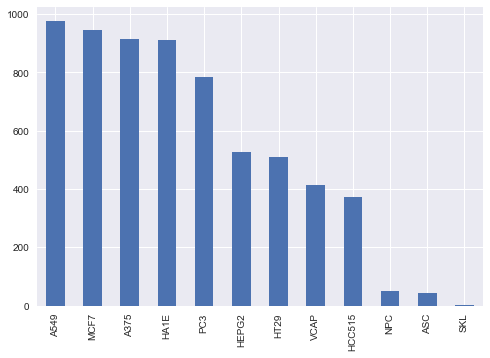

In [17]:
# which cell lines are most common?
all_cell_list = np.array(functools.reduce( lambda x,y: x+y, [ list(s) for s in true_pair_common_cells ] ))
cell_line_counts = pd.Series(all_cell_list).value_counts()
cell_line_counts.plot.bar()
plt.show()

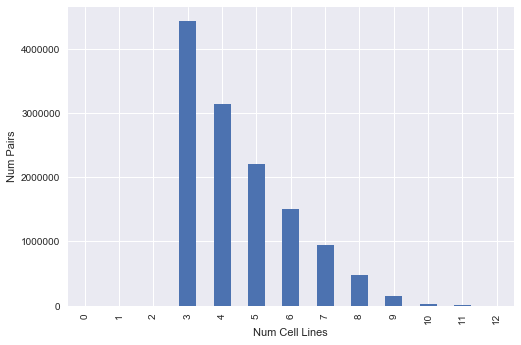

In [18]:
# how many pairs tested in at least n cell lines?
num_common_cells_5 = np.array([ len(cells) for cells in common_cells_5_])
pair_set_5_df['ncells'] = num_common_cells_5
ncell_counts = pair_set_5_df.ncells.value_counts()
cum_ncell_counts = [0,0,0]
for i in ncell_counts.index:
    cum_ncell_counts.append(sum(ncell_counts.loc[i:]))
cum_ncell_counts = pd.Series(cum_ncell_counts)
cum_ncell_counts.plot.bar()
plt.ylabel('Num Pairs')
plt.xlabel('Num Cell Lines')
plt.show()

## 6. Most common cell lines (pair set 6)
Three of the cell lines have very few drugs. We can ignore them and just focus on data from the 9 most common cell lines. 

**This also has to be done in batches**

In [19]:
top_9_cell_lines = set(cell_line_counts.index[:9])

In [18]:
# filter out pairs not in the top-9 cell lines
for j in range(10):
    print('BATCH {}'.format(j))
    cpd_6_, target_6_, label_6_, common_cells_6_, common_partners_6_ = [], [], [], [], []
    
    print('LOADING DATA')
    df_filename = 'checkpoint_files/pair_set_5_df_{}.csv'.format(j)
    cc_filename = 'checkpoint_files/common_cells_5_{}.sav'.format(j)
    cp_filename = 'checkpoint_files/common_partners_5_{}.sav'.format(j)
    
    p_5_df = pd.DataFrame.from_csv(df_filename)
    
    cc_5_file = open(cc_filename, 'rb')
    cc_5_ = pickle.load(cc_5_file)
    cc_5_file.close()
    
    cp_5_file = open(cp_filename, 'rb')
    cp_5_ = pickle.load(cp_5_file)
    cp_5_file.close()
    
    print('FILTERING DATA')
    for index, row in log_progress(p_5_df.iterrows(), every=5000):
        common_cells = cc_5_[index]
        top_common_cells = common_cells & top_9_cell_lines
        if len(top_common_cells) >= min_num_cells:
            cpd_6_.append(row.cpd)
            target_6_.append(row.target)
            label_6_.append(row.label)
            common_cells_6_.append(top_common_cells)

            common_partners = {}
            for c in top_common_cells:
                common_partners[c] = cp_5_[index][c]
            common_partners_6_.append(common_partners)
            
    print('MAKING DATAFRAME')
    pair_set_6_df = pd.DataFrame({'cpd': cpd_6_, 'target': target_6_, 'label': label_6_})

    print('SAVING DATAFRAME')
    df_filename = 'checkpoint_files/pair_set_6_df_{}.csv'.format(j)
    pair_set_6_df.to_csv(df_filename)

    print('SAVING COMMON CELLS')
    cc_filename = 'checkpoint_files/common_cells_6_{}.sav'.format(j)
    cc_file = open(cc_filename, 'wb')
    pickle.dump(common_cells_6_, cc_file)
    cc_file.close()

    print('SAVING COMMON PARTNERS')
    cp_filename = 'checkpoint_files/common_partners_6_{}.sav'.format(j)
    cp_file = open(cp_filename, 'wb')
    pickle.dump(common_partners_6_, cp_file)
    cp_file.close()

    print('RESETTING MEMORY')
    cpd_6_, target_6_, label_6_, common_cells_6_, common_partners_6_ = None, None, None, None, None
    p_5_df, cc_5_, cp_5_ = None, None, None
    
    
    print('DONE\n')

BATCH 0
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 1
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 2
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 3
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 4
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 5
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 6
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 7
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 8
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 9
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE



In [27]:
# LOAD DATA AND put the pieces back together
pair_set_6_df = pd.DataFrame(columns=['cpd', 'label', 'target'])
common_cells_6_ = []
common_partners_6_ = []

for j in log_progress(range(10)):
    df_filename = 'checkpoint_files/pair_set_6_df_{}.csv'.format(j)
    cc_filename = 'checkpoint_files/common_cells_6_{}.sav'.format(j)
    cp_filename = 'checkpoint_files/common_partners_6_{}.sav'.format(j)
    
    pair_set_6_df = pair_set_6_df.append(pd.DataFrame.from_csv(df_filename))
    #common_cells_6_ += pickle.load(open(cc_filename, 'rb'))
    #common_partners_5_ += pickle.load(open(cp_filename, 'rb'))

In [20]:
print('Pair set 6 statistics\n')
print('No. True interactions:\t', pair_set_6_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_6_df[pair_set_6_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_6_df[pair_set_6_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_6_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_6_df[pair_set_6_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_6_df[pair_set_6_df.label == 0].target.unique()))

Pair set 6 statistics

No. True interactions:	 1303
No. True cpds:		 229
No. True genes:		 302

No. False interactions:	 4394682
No. False cpds:		 1180
No. False genes:	 3245


___
# Extract gene expression signatures

### Compounds

In [165]:
# load filtered data
pair_set_6_df = pickle.load(open('checkpoint_files/pair_set_6_df.sav', 'rb'))
common_cells_6_ = pickle.load(open('checkpoint_files/common_cells_6_.sav', 'rb'))
#common_partners_6_ = pickle.load(open('checkpoint_files/common_partners_7_', 'rb'))

In [123]:
# reference lists
top_9_cell_line_cpds = pair_set_6_df.cpd.unique()
top_9_cell_line_kds = list(repr_kd_sig_info_dict.keys())

gene_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
lm_genes = gene_info_1[gene_info_1['pr_is_lm'].astype(bool)]
lm_gene_ids = lm_genes['pr_gene_id'].astype(str).values

In [20]:
# select representatives
repr_top_9_cpd_sigs = pd.DataFrame(columns=all_cpd_sig_info.columns)
for pert_id in log_progress(top_9_cell_line_cpds):
    repr_cpd_sigs = repr_cpd_sig_info_dict[pert_id]
    repr_cpd_sigs = repr_cpd_sigs[repr_cpd_sigs.cell_id.isin(top_9_cell_lines)]
    repr_top_9_cpd_sigs = repr_top_9_cpd_sigs.append(repr_cpd_sigs)

In [21]:
# extract the actual signatures
phase_1_sig_ids = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', col_meta_only=True).index.values
phase_2_sig_ids = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', col_meta_only=True).index.values

# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_9_cpd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_top_9_cpd_sigs.sig_id.values ]
phase_1_top_9_cpd_sig_ids = [ s for s in top_9_cpd_sig_ids if s in phase_1_sig_ids ]
phase_2_top_9_cpd_sig_ids = [ s for s in top_9_cpd_sig_ids if s in phase_2_sig_ids ]

# extract the actual signatures
phase_1_top_9_cpd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_9_cpd_sig_ids).data_df
phase_2_top_9_cpd_sigs = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', cid=phase_2_top_9_cpd_sig_ids).data_df
phase_2_top_9_cpd_sigs.rename(lambda x: x[2:-1], inplace=True)
top_9_cpd_raw_sigs = pd.concat([phase_1_top_9_cpd_sigs, phase_2_top_9_cpd_sigs], axis=1)

# discard all but landmark gene values
top_9_cpd_lm_sigs = top_9_cpd_raw_sigs[top_9_cpd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_9_cpd_lm_sigs = top_9_cpd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_9_cpd_lm_sigs.head()

KeyboardInterrupt: 

In [ ]:
print(repr_top_9_cpd_sigs.shape)
print(top_9_cpd_lm_sigs.shape)
repr_top_9_cpd_sigs.to_csv('checkpoint_files/repr_top_9_cpd_sigs.csv')
top_9_cpd_lm_sigs.to_csv('checkpoint_files/top_9_cpd_lm_sigs.csv')

### Knockdowns

In [124]:
# select representatives
repr_top_9_kd_sigs = pd.DataFrame(columns=all_kd_sig_info.columns)
for pert_iname in log_progress(top_9_cell_line_kds):
    repr_kd_sigs = repr_kd_sig_info_dict[pert_iname]
    repr_kd_sigs = repr_kd_sigs[repr_kd_sigs.cell_id.isin(top_9_cell_lines)]
    repr_top_9_kd_sigs = repr_top_9_kd_sigs.append(repr_kd_sigs)

In [127]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_9_kd_sig_ids = [ str(s.encode('UTF8')) for s in repr_top_9_kd_sigs.sig_id.values ]

# read in the data
top_9_kd_raw_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=top_9_kd_sig_ids).data_df

# discard non-landmark gene expression scores
top_9_kd_lm_sigs = top_9_kd_raw_sigs[top_9_kd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_9_kd_lm_sigs = top_9_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_9_kd_lm_sigs.head()

cid,DER001_A375_96H:TRCN0000197159:-666,DER001_A375_96H:TRCN0000006029:-666,DER001_A375_96H:TRCN0000338772:-666,DER001_A375_96H:TRCN0000218565:-666,DER001_A375_96H:TRCN0000369366:-666,DER001_A375_96H:TRCN0000138966:-666,DER001_A375_96H:TRCN0000262375:-666,DER001_A375_96H:TRCN0000141905:-666,DER001_A375_96H:TRCN0000350521:-666,DER001_A375_96H:TRCN0000051204:-666,...,KDB001_PC3_96H:TRCN0000343797:-666,KDB001_PC3_96H:TRCN0000319318:-666,KDB001_PC3_96H:TRCN0000323290:-666,KDB001_PC3_96H:TRCN0000159391:-666,KDB001_PC3_96H:TRCN0000364667:-666,KDB001_PC3_96H:TRCN0000135504:-666,KDB001_PC3_96H:TRCN0000142389:-666,KDB001_PC3_96H:TRCN0000180510:-666,KDB001_PC3_96H:TRCN0000254328:-666,KDB001_PC3_96H:TRCN0000133950:-666
rid,,,,,,,,,,,,,,,,,,,,,
10007,-1.582821,1.147524,-0.233997,0.705900,-0.493815,-0.215770,0.451134,-0.327473,-0.766019,2.288669,...,-0.39430,0.39255,0.40935,1.98080,0.46525,-0.81515,-0.31605,-0.02665,0.36655,1.32305
1001,-0.037421,1.322280,0.614880,-0.021201,1.828483,1.179174,-0.062841,0.722374,0.865695,0.364353,...,0.75325,-0.32005,-1.70935,0.82750,0.14065,-0.61405,-0.14040,0.64610,1.46140,0.01925
10013,0.156317,0.654752,1.081601,0.210859,0.883683,-0.093974,1.296774,-1.416878,-0.155374,-0.297705,...,-0.43025,-0.46250,-0.24895,0.34875,-0.56190,0.47240,-0.57825,-0.82385,0.35615,0.69620
10038,0.717362,0.046802,0.573958,-1.193527,-0.049510,0.716104,1.441153,-0.215514,0.236909,-1.513038,...,-0.14960,-0.22880,0.61105,-2.17760,0.02495,0.22810,-1.60735,0.69330,-0.59275,-0.38195
10046,-0.171960,1.246416,4.340301,-0.888133,0.597416,1.460984,-1.016598,0.117003,0.889986,0.808288,...,-0.15285,-0.22195,-0.83325,0.00205,-1.43080,0.42020,-0.35985,0.94590,-0.75705,0.32970


In [128]:
print(repr_top_9_kd_sigs.shape)
print(top_9_kd_lm_sigs.shape)
repr_top_9_kd_sigs.to_csv('checkpoint_files/repr_top_9_kd_sigs.csv')
top_9_kd_lm_sigs.to_csv('checkpoint_files/top_9_kd_lm_sigs.csv')

(30323, 15)
(978, 30323)


___
## Feature construction

### Direct Correlation

In [24]:
# load data
repr_top_9_cpd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_9_cpd_sigs.csv')
top_9_cpd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_9_cpd_lm_sigs.csv')
print(repr_top_9_cpd_sigs.shape)
print(top_9_cpd_lm_sigs.shape)

(6098, 15)
(978, 6098)


In [111]:
# load data
repr_top_9_kd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_9_kd_sigs.csv')
top_9_kd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_9_kd_lm_sigs.csv')
print(repr_top_9_kd_sigs.shape)
print(top_9_kd_lm_sigs.shape)

(25386, 15)
(978, 25386)


In [28]:
# reset memory
pair_set_4_df = None
pair_set_5_df = None
common_cells_4_ = None
common_cells_5_ = None

We'll try to run this in parallel since it is SUPER slow.

In [44]:
len(pair_set_6_df)

4395985

In [34]:
import multiprocessing
num_processes = 4 #multiprocessing.cpu_count()

In [ ]:
def compute_dir_corr(pair_subset):
    
    # initialize empty dataframe to hold direct correlation values
    dir_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_9_cell_lines)

    # loop through cpd-target pairs, calculate correlations in each cell line
    for index, row in log_progress(pair_subset.iterrows(), every=1):
        if index % 1000 == 0: print('INDEX: {}'.format(index))
        
        cpd = row.cpd
        cpd_sig_info = repr_cpd_sig_info_dict[cpd]
        kd = row.target
        kd_sig_info = repr_kd_sig_info_dict[kd]
        
        for cell_line in top_9_cell_lines:
            cpd_cell_sig_info = cpd_sig_info[cpd_sig_info.cell_id == cell_line]
            kd_cell_sig_info = kd_sig_info[kd_sig_info.cell_id == cell_line]

            # remember we have missing data, not all pairs are tested in all cell lines
            if not (cpd_cell_sig_info.empty or kd_cell_sig_info.empty):
                # extract signatures
                cpd_sig_id = cpd_cell_sig_info.sig_id
                kd_sig_id = kd_cell_sig_info.sig_id
                cpd_lm_sig = top_9_cpd_lm_sigs[cpd_sig_id].values
                kd_lm_sig = top_9_kd_lm_sigs[kd_sig_id].values
                #compute and store correlation
                corr = scipy.stats.pearsonr(cpd_lm_sig, kd_lm_sig)[0][0]
                dir_corr_df.at[index, cell_line] = corr
    
    return dir_corr_df

In [37]:
# break the pairs up into batches
num_batches = 10
batch_size = 450000 # len(pair_set_6_df) / num_batches = 439598.5
pdf6_batches = [ pair_set_6_df.iloc[pair_set_6_df.index[i:i + batch_size]].reset_index(drop=True)for i in range(0,num_batches*batch_size,batch_size) ]

In [38]:
# run the filter on each batch of the data
for j in range(10):
    
    print('STARTING BATCH: ', j)
    # reset memory
    result = None
    dir_corr_sub_df = None
    
    # get data
    pdf6_batch = pdf6_batches[j]

    # calculate the chunk size as an integer
    chunk_size = int(pdf6_batch.shape[0]/num_processes)

    # break the dataframe up into chunks
    pair_chunks = [ pdf6_batch.iloc[pdf6_batch.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pdf6_batch.shape[0], chunk_size)]

    # filter each section of the pairs dataframe in parallel
    pool = multiprocessing.Pool(processes=num_processes)
    result = pool.map(compute_dir_corr, pair_chunks)
    pool.close()
    
    dir_corr_sub_df = functools.reduce(lambda x,y: pd.concat([x,y]), result)
    filename = 'features/top_9_dir_corr_sub_df_{}.csv'.format(j)
    dir_corr_sub_df.to_csv(filename)

STARTING BATCH:  0
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 4000
INDEX: 4000
INDEX: 5000
INDEX: 4000
INDEX: 4000
INDEX: 5000
INDEX: 6000
INDEX: 5000
INDEX: 5000
INDEX: 6000
INDEX: 7000
INDEX: 6000
INDEX: 7000
INDEX: 6000
INDEX: 8000
INDEX: 7000
INDEX: 8000
INDEX: 9000
INDEX: 7000
INDEX: 8000
INDEX: 9000
INDEX: 10000
INDEX: 8000
INDEX: 9000
INDEX: 10000
INDEX: 9000
INDEX: 10000
INDEX: 11000
INDEX: 11000
INDEX: 11000
INDEX: 10000
INDEX: 12000
INDEX: 12000
INDEX: 13000
INDEX: 12000
INDEX: 11000
INDEX: 13000
INDEX: 14000
INDEX: 13000
INDEX: 12000
INDEX: 14000
INDEX: 15000
INDEX: 16000
INDEX: 14000
INDEX: 15000
INDEX: 13000
INDEX: 17000
INDEX: 15000
INDEX: 14000
INDEX: 16000
INDEX: 18000
INDEX: 16000
INDEX: 17000
INDEX: 15000
INDEX: 19000
INDEX: 18000
INDEX: 17000
INDEX: 16000
INDEX: 20000
INDEX: 19000
INDEX: 17000
INDEX: 18000
INDEX: 21000
INDEX:

INDEX: 44000
INDEX: 46000
INDEX: 46000
INDEX: 44000
INDEX: 45000
INDEX: 47000
INDEX: 47000
INDEX: 45000
INDEX: 46000
INDEX: 48000
INDEX: 48000
INDEX: 46000
INDEX: 47000
INDEX: 49000
INDEX: 49000
INDEX: 48000
INDEX: 50000
INDEX: 47000
INDEX: 50000
INDEX: 51000
INDEX: 49000
INDEX: 51000
INDEX: 48000
INDEX: 52000
INDEX: 52000
INDEX: 50000
INDEX: 49000
INDEX: 53000
INDEX: 53000
INDEX: 51000
INDEX: 50000
INDEX: 54000
INDEX: 52000
INDEX: 54000
INDEX: 51000
INDEX: 55000
INDEX: 53000
INDEX: 55000
INDEX: 52000
INDEX: 56000
INDEX: 54000
INDEX: 53000
INDEX: 56000
INDEX: 57000
INDEX: 54000
INDEX: 55000
INDEX: 57000
INDEX: 58000
INDEX: 55000
INDEX: 56000
INDEX: 59000
INDEX: 58000
INDEX: 56000
INDEX: 57000
INDEX: 60000
INDEX: 59000
INDEX: 57000
INDEX: 58000
INDEX: 61000
INDEX: 60000
INDEX: 58000
INDEX: 59000
INDEX: 62000
INDEX: 61000
INDEX: 60000
INDEX: 59000
INDEX: 63000
INDEX: 62000
INDEX: 61000
INDEX: 64000
INDEX: 60000
INDEX: 63000
INDEX: 62000
INDEX: 65000
INDEX: 61000
INDEX: 64000
INDEX: 63000

INDEX: 88000
INDEX: 90000
INDEX: 90000
INDEX: 89000
INDEX: 89000
INDEX: 91000
INDEX: 91000
INDEX: 90000
INDEX: 90000
INDEX: 92000
INDEX: 91000
INDEX: 92000
INDEX: 91000
INDEX: 93000
INDEX: 92000
INDEX: 93000
INDEX: 92000
INDEX: 94000
INDEX: 93000
INDEX: 93000
INDEX: 94000
INDEX: 95000
INDEX: 94000
INDEX: 94000
INDEX: 95000
INDEX: 96000
INDEX: 95000
INDEX: 95000
INDEX: 96000
INDEX: 97000
INDEX: 96000
INDEX: 96000
INDEX: 97000
INDEX: 98000
INDEX: 97000
INDEX: 99000
INDEX: 97000
INDEX: 98000
INDEX: 98000
INDEX: 100000
INDEX: 99000
INDEX: 98000
INDEX: 99000
INDEX: 101000
INDEX: 100000
INDEX: 99000
INDEX: 102000
INDEX: 100000
INDEX: 101000
INDEX: 100000
INDEX: 103000
INDEX: 101000
INDEX: 101000
INDEX: 102000
INDEX: 104000
INDEX: 102000
INDEX: 103000
INDEX: 102000
INDEX: 105000
INDEX: 103000
INDEX: 103000
INDEX: 106000
INDEX: 104000
INDEX: 107000
INDEX: 104000
INDEX: 105000
INDEX: 104000
INDEX: 108000
INDEX: 105000
INDEX: 106000
INDEX: 105000
INDEX: 109000
INDEX: 107000
INDEX: 106000
INDEX: 

INDEX: 21000
INDEX: 21000
INDEX: 20000
INDEX: 19000
INDEX: 22000
INDEX: 22000
INDEX: 21000
INDEX: 20000
INDEX: 23000
INDEX: 23000
INDEX: 22000
INDEX: 21000
INDEX: 24000
INDEX: 24000
INDEX: 23000
INDEX: 22000
INDEX: 25000
INDEX: 25000
INDEX: 24000
INDEX: 23000
INDEX: 26000
INDEX: 26000
INDEX: 24000
INDEX: 25000
INDEX: 27000
INDEX: 25000
INDEX: 27000
INDEX: 26000
INDEX: 28000
INDEX: 26000
INDEX: 28000
INDEX: 29000
INDEX: 27000
INDEX: 27000
INDEX: 30000
INDEX: 28000
INDEX: 29000
INDEX: 28000
INDEX: 31000
INDEX: 29000
INDEX: 30000
INDEX: 29000
INDEX: 32000
INDEX: 30000
INDEX: 31000
INDEX: 33000
INDEX: 30000
INDEX: 31000
INDEX: 32000
INDEX: 34000
INDEX: 31000
INDEX: 32000
INDEX: 33000
INDEX: 35000
INDEX: 33000
INDEX: 34000
INDEX: 32000
INDEX: 36000
INDEX: 34000
INDEX: 33000
INDEX: 35000
INDEX: 37000
INDEX: 35000
INDEX: 34000
INDEX: 36000
INDEX: 36000
INDEX: 38000
INDEX: 35000
INDEX: 37000
INDEX: 37000
INDEX: 36000
INDEX: 39000
INDEX: 38000
INDEX: 38000
INDEX: 37000
INDEX: 39000
INDEX: 40000

INDEX: 65000
INDEX: 65000
INDEX: 66000
INDEX: 65000
INDEX: 63000
INDEX: 67000
INDEX: 64000
INDEX: 66000
INDEX: 66000
INDEX: 68000
INDEX: 65000
INDEX: 67000
INDEX: 67000
INDEX: 69000
INDEX: 66000
INDEX: 68000
INDEX: 70000
INDEX: 68000
INDEX: 67000
INDEX: 69000
INDEX: 71000
INDEX: 68000
INDEX: 69000
INDEX: 70000
INDEX: 72000
INDEX: 69000
INDEX: 70000
INDEX: 73000
INDEX: 71000
INDEX: 70000
INDEX: 74000
INDEX: 71000
INDEX: 72000
INDEX: 71000
INDEX: 75000
INDEX: 73000
INDEX: 72000
INDEX: 72000
INDEX: 76000
INDEX: 74000
INDEX: 73000
INDEX: 73000
INDEX: 77000
INDEX: 75000
INDEX: 74000
INDEX: 74000
INDEX: 78000
INDEX: 76000
INDEX: 75000
INDEX: 75000
INDEX: 79000
INDEX: 77000
INDEX: 76000
INDEX: 76000
INDEX: 80000
INDEX: 78000
INDEX: 77000
INDEX: 77000
INDEX: 81000
INDEX: 78000
INDEX: 79000
INDEX: 78000
INDEX: 82000
INDEX: 79000
INDEX: 80000
INDEX: 79000
INDEX: 83000
INDEX: 80000
INDEX: 81000
INDEX: 80000
INDEX: 84000
INDEX: 81000
INDEX: 82000
INDEX: 81000
INDEX: 85000
INDEX: 82000
INDEX: 83000

INDEX: 111000
INDEX: 110000
INDEX: 112000
INDEX: 106000
INDEX: 106000
INDEX: 111000
INDEX: 107000
INDEX: 107000
INDEX: 112000
INDEX: 108000
INDEX: 108000
INDEX: 109000
INDEX: 109000
INDEX: 110000
INDEX: 110000
INDEX: 111000
INDEX: 111000
INDEX: 112000
INDEX: 112000
STARTING BATCH:  7
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 4000
INDEX: 4000
INDEX: 4000
INDEX: 5000
INDEX: 4000
INDEX: 5000
INDEX: 5000
INDEX: 6000
INDEX: 5000
INDEX: 6000
INDEX: 6000
INDEX: 7000
INDEX: 6000
INDEX: 7000
INDEX: 7000
INDEX: 8000
INDEX: 7000
INDEX: 8000
INDEX: 8000
INDEX: 8000
INDEX: 9000
INDEX: 9000
INDEX: 9000
INDEX: 10000
INDEX: 9000
INDEX: 10000
INDEX: 11000
INDEX: 10000
INDEX: 10000
INDEX: 11000
INDEX: 12000
INDEX: 11000
INDEX: 11000
INDEX: 12000
INDEX: 13000
INDEX: 12000
INDEX: 14000
INDEX: 12000
INDEX: 13000
INDEX: 13000
INDEX: 15000
INDEX: 13000
INDEX: 14000


INDEX: 38000
INDEX: 39000
INDEX: 42000
INDEX: 40000
INDEX: 39000
INDEX: 40000
INDEX: 43000
INDEX: 41000
INDEX: 40000
INDEX: 41000
INDEX: 44000
INDEX: 42000
INDEX: 41000
INDEX: 42000
INDEX: 45000
INDEX: 43000
INDEX: 43000
INDEX: 42000
INDEX: 46000
INDEX: 44000
INDEX: 44000
INDEX: 47000
INDEX: 43000
INDEX: 45000
INDEX: 45000
INDEX: 48000
INDEX: 44000
INDEX: 46000
INDEX: 46000
INDEX: 45000
INDEX: 49000
INDEX: 47000
INDEX: 47000
INDEX: 46000
INDEX: 50000
INDEX: 48000
INDEX: 48000
INDEX: 47000
INDEX: 51000
INDEX: 49000
INDEX: 49000
INDEX: 48000
INDEX: 52000
INDEX: 50000
INDEX: 50000
INDEX: 49000
INDEX: 53000
INDEX: 51000
INDEX: 50000
INDEX: 51000
INDEX: 54000
INDEX: 52000
INDEX: 51000
INDEX: 55000
INDEX: 52000
INDEX: 53000
INDEX: 56000
INDEX: 52000
INDEX: 53000
INDEX: 54000
INDEX: 57000
INDEX: 53000
INDEX: 54000
INDEX: 55000
INDEX: 54000
INDEX: 58000
INDEX: 55000
INDEX: 56000
INDEX: 55000
INDEX: 56000
INDEX: 59000
INDEX: 57000
INDEX: 56000
INDEX: 57000
INDEX: 58000
INDEX: 60000
INDEX: 57000

INDEX: 85000
INDEX: 81000
INDEX: 86000
INDEX: 84000
INDEX: 86000


INDEX: 0
INDEX: 82000
INDEX: 85000
INDEX: 83000
INDEX: 84000
INDEX: 86000
INDEX: 85000
INDEX: 86000


In [41]:
# LOAD CORRELATION DATA AND put the pieces back together
dir_corr_df = pd.DataFrame(columns=top_9_cell_lines)
for j in log_progress(range(10)):
    df_filename = 'features/top_9_dir_corr_sub_df_{}.csv'.format(j)
    dir_corr_df = dir_corr_df.append(pd.DataFrame.from_csv(df_filename))

In [42]:
dir_corr_df.shape

(4395985, 9)

### Indirect Correlation

In [ ]:
for j in range(1,10):
    print('LOADING BATCH: {}'.format(j))
    df_filename = 'checkpoint_files/pair_set_6_df_{}.csv'.format(j)
    cp_filename = 'checkpoint_files/common_partners_6_{}.sav'.format(j)
    pair_subset = pd.DataFrame.from_csv(df_filename)
    partner_subset = pickle.load(open(cp_filename, 'rb'))
    
    print('CHUNKING DATA')
    chunk_size = int(pair_subset.shape[0]/num_processes)
    # break the dataframe up into chunks
    pair_chunks = [ pair_subset.iloc[pair_subset.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pair_subset.shape[0], chunk_size)]
    partner_chunks = [ partner_subset[i:i + chunk_size] for i in range(0, len(partner_subset), chunk_size) ]
    chunks = list(zip(pair_chunks, partner_chunks))

    print('SPAWNING PROCESSES')
    # compute indirect correlations for each chunk in parallel
    pool = multiprocessing.Pool(processes=num_processes)
    result = pool.map(compute_indir_corr, chunks)
    pool.close()

    print('COLLECTION RESULTS')
    max_dfs, min_dfs, avg_dfs = zip(*result)
    indir_max_corr_df = functools.reduce(lambda x,y: pd.concat([x,y]), max_dfs)
    indir_min_corr_df = functools.reduce(lambda x,y: pd.concat([x,y]), min_dfs)
    indir_avg_corr_df = functools.reduce(lambda x,y: pd.concat([x,y]), avg_dfs)

    print('SAVING TO DISK')
    max_df_filename = 'features/top_9_indir_max_corr_sub_df_{}.csv'.format(j)
    min_df_filename = 'features/top_9_indir_min_corr_sub_df_{}.csv'.format(j)
    avg_df_filename = 'features/top_9_indir_avg_corr_sub_df_{}.csv'.format(j)

    indir_max_corr_df.to_csv(max_df_filename)
    indir_min_corr_df.to_csv(min_df_filename)
    indir_avg_corr_df.to_csv(avg_df_filename)
    
    print('CLEARING VARIABLES')
    max_dfs, min_dfs, avg_dfs = None, None, None
    indir_max_corr_df, indir_min_corr_df, indir_avg_corr_df = None, None, None
    
    print('DONE\n')

LOADING BATCH: 1
CHUNKING DATA
SPAWNING PROCESSES
0
10
20
0
30
40
50
230
60
10
70
20
80
30
90
40
50
100
60
70
110
80
90
120
100
130
110
140
120
150
160
130
170
140
180
150
190
200
160
210
170
220
180
190
240
200
250
210
220
260
230
270
240
250
280
0
290
10
260
20
270
300
30
280
40
310
50
320
290
60
300
330
70
310
320
80
330
340
90
340
100
350
110
120
350
130
140
360
360
150
370
160
370
380
170
380
390
180
390
400
190
410
420
200
430
440
400
450
210
220
410
460
230
470
0
240
480
420
490
250
10
500
430
510
440
20
260
520
450
270
530
30
460
280
40
540
550
290
300
560
310
50
320
570
330
580
470
60
340
480
590
350
360
490
70
600
500
370
610
380
80
390
510
620
400
90
410
520
420
530
100
430
630
540
110
550
440
120
640
560
450
570
650
580
460
130
590
470
600
660
140
480
610
670
490
620
150
630
680
500
690
160
640
700
510
170
650
710
520
660
720
530
670
540
180
730
550
680
740
690
560
700
570
750
580
190
760
710
200
770
590
210
600
720
780
220
610
790
800
730
810
620
230
740
820
750
830
760
63

4330
4390
4340
4400
5470
4350
4410
2990
5480
4360
4420
5490
4430
3000
4440
4370
5500
4450
3010
4460
4380
5510
4470
3020
4480
5520
3030
4390
4490
5530
3040
4500
4510
5540
4520
4400
3050
5550
4530
4410
4420
4540
5560
3060
4550
5570
4430
4440
4560
5580
3070
4450
5590
4570
5600
4460
5610
4580
4590
3080
4470
5620
4600
4480
5630
4490
4610
5640
3090
4500
4620
5650
4510
3100
4630
4520
4640
5660
4530
3110
4650
4540
3120
4660
5670
4550
4670
4680
4690
4560
4700
5680
4710
5690
4720
4570
4730
4740
3130
4750
4580
4760
5700
4770
4590
4780
4600
4790
4800
4810
5710
4820
3140
4830
4610
4840
4850
4860
4620
4870
5720
4880
4890
4900
4910
4920
4630
3150
5730
4930
4940
4950
5740
3160
4640
4960
4970
4650
4980
5750
3170
4990
4660
5000
5760
5010
5020
5770
5030
5780
4670
3180
5790
5040
5050
5800
5810
5060
5820
5070
4680
3190
5830
5080
5840
3200
5090
3210
5850
5100
4690
3220
5860
5110
3230
5870
5880
3240
5120
5130
5890
3250
5140
4700
5900
3260
5150
5910
5920
3270
5160
5930
5170
5180
5940
4710
3280
5190
5950
5200


5960
7990
10250
9320
5970
10260
8000
9330
10270
9340
8010
10280
10290
9350
8020
10300
10310
5980
9360
10320
9370
5990
10330
8030
9380
10340
9390
10350
8040
6000
10360
9400
10370
8050
10380
9410
10390
9420
10400
8060
6010
10410
9430
10420
9440
8070
9450
10430
6020
8080
9460
10440
8090
9470
6030
6040
10450
9480
9490
10460
9500
8100
10470
6050
9510
6060
9520
8110
10480
9530
6070
10490
8120
8130
10500
9540
10510
6080
8140
10520
9550
6090
9560
10530
8150
9570
6100
9580
10540
9590
6110
8160
10550
9600
10560
10570
9610
6120
8170
9620
10580
9630
10590
10600
8180
9640
10610
10620
6130
8190
10630
10640
10650
9650
8200
10660
10670
6140
9660
10680
10690
6150
10700
10710
8210
9670
10720
9680
6160
10730
10740
9690
10750
8220
10760
10770
9700
10780
10790
6170
9710
10800
10810
8230
10820
9720
6180
10830
8240
10840
9730
10850
9740
6190
8250
9750
10860
6200
9760
8260
8270
10870
9770
8280
6210
8290
8300
8310
10880
8320
6220
8330
9780
10890
8340
9790
6230
8350
9800
8360
8370
9810
8380
6240
8390
8400
9820


12970
10030
11620
12980
13680
10040
11630
12990
13690
10050
13000
11640
11650
10060
13700
11660
10070
13710
11670
10080
13720
11680
13010
11690
13730
13020
10090
13030
13740
10100
13040
13750
10110
11700
11710
13050
13060
11720
13760
10120
13070
11730
13080
13770
13090
10130
13780
11740
13100
13110
10140
11750
13120
13790
13130
10150
13140
11760
10160
13150
13800
11770
13160
11780
13810
13170
10170
11790
13180
13820
13190
10180
11800
13830
13200
10190
13840
13210
11810
13220
10200
13850
13230
13860
13240
11820
13870
10210
13880
13250
11830
10220
13890
13260
10230
13900
11840
13270
13910
10240
13920
13280
13290
10250
13300
13930
11850
10260
13940
13310
13950
13320
11860
13960
10270
13970
13330
13980
13990
11870
13340
10280
11880
14000
13350
14010
10290
11890
14020
13360
10300
11900
14030
14040
11910
14050
11920
13370
11930
14060
13380
11940
14070
11950
10310
14080
11960
10320
11970
14090
10330
13390
11980
14100
11990
10340
12000
10350
14110
12010
10360
14120
12020
13400
10370
10380
1413

17280
13610
13620
13630
15850
17290
15220
13640
15860
17300
13650
15870
15230
17310
15240
13660
15880
17320
15890
13670
17330
15250
17340
15900
15260
13680
15910
15270
15920
13690
17350
13700
15280
13710
15930
15290
17360
13720
15300
13730
15940
15310
13740
17370
13750
15950
15320
15960
13760
15330
15970
13770
15980
15340
17380
13780
15990
13790
13800
15350
13810
16000
13820
16010
17390
13830
17400
15360
13840
16020
17410
15370
13850
16030
13860
17420
17430
13870
15380
13880
17440
16040
17450
13890
17460
15390
17470
13900
16050
17480
15400
17490
13910
16060
17500
13920
13930
17510
13940
15410
17520
15420
13950
16070
13960
15430
13970
15440
16080
17530
13980
15450
15460
17540
13990
15470
16090
14000
15480
14010
17550
15490
14020
16100
15500
14030
17560
16110
15510
14040
17570
14050
17580
15520
16120
14060
15530
14070
16130
14080
17590
14090
15540
17600
14100
16140
15550
14110
17610
14120
14130
17620
15560
16150
14140
15570
14150
16160
14160
17630
14170
16170
14180
15580
17640
16180
1419

19110
18400
18220
19890
18410
18230
18420
19120
18240
18430
18440
18250
19900
18450
18260
19130
18460
18270
18470
18280
18290
18480
18490
19140
18500
18300
18510
18520
18310
19150
18530
18320
19910
18540
18330
18550
18340
18560
19920
19160
18570
18350
18580
18360
19930
18590
18370
18600
19170
18610
18380
18620
18630
18640
18390
19940
18650
18660
18400
19180
18670
18680
18410
18690
19190
18700
19950
18710
18420
18720
19200
18730
18430
19960
18740
19970
18750
18440
19210
18760
19980
18450
18770
18460
19990
18780
18470
20000
19220
18790
20010
18480
18800
20020
18810
18820
19230
20030
18490
18830
20040
18840
18500
18850
20050
18860
18510
19240
18870
20060
18520
18880
18530
20070
18890
20080
18900
20090
18540
19250
18910
20100
20110
18550
20120
18920
18560
20130
18930
18570
20140
19260
18940
20150
18950
18580
20160
18590
18960
20170
18600
18610
18970
19270
18620
18630
20180
18980
20190
18640
18650
20200
18990
20210
18660
19000
18670
19010
19280
20220
19020
18680
18690
19030
19290
18700
1904

23430
23170
23440
23180
21600
21080
23450
21610
23460
23190
21620
23470
23480
21630
21090
23490
23200
23500
21640
23510
23520
23210
23530
21100
23220
21650
23540
23550
23230
23560
23570
21660
23240
21110
23580
23250
23590
21670
23260
23600
23610
21680
23270
23620
21690
23280
23630
21700
23290
23640
23300
21120
23650
23310
21710
23660
21130
21720
23670
23320
23680
23330
21730
21140
23340
23690
21150
21740
23350
23700
23710
23720
23360
23730
23740
23370
23750
21750
21160
23380
23760
23390
23770
23400
23780
23410
23790
23420
21760
23430
23800
21170
23440
21770
23810
23820
23450
23830
23460
21780
21180
23840
23470
23480
23850
23490
21790
21190
23500
23860
23510
23520
23870
21200
23530
23880
21800
23890
23540
23900
23550
21210
23560
23910
21810
23570
23580
23920
21220
23930
23590
21820
23940
23600
21830
21230
23950
23960
23970
21840
23980
23610
23990
21240
24000
21850
23620
24010
21860
21250
23630
24020
24030
24040
21260
21870
23640
24050
21880
24060
23650
21890
21270
24070
21900
23660
2408

26180
27010
23450
26300
27020
26190
26310
26200
27030
26210
26320
26220
23460
26330
26230
26240
26340
26250
23470
27040
26260
26350
26270
23480
26360
27050
26370
23490
26280
26380
23500
26390
26400
23510
26290
23520
26410
27060
26300
26420
26310
23530
26430
26320
23540
26440
27070
26330
26450
23550
26340
26350
23560
26460
27080
26360
27090
23570
26470
26370
26480
26380
27100
26490
23580
27110
26390
26500
27120
26400
23590
26510
26410
23600
27130
26520
23610
27140
23620
26420
26530
27150
27160
26430
26540
27170
26550
27180
26440
23630
26560
27190
26570
26450
23640
27200
26580
27210
23650
26460
27220
26590
26470
23660
26600
27230
26610
23670
26480
26620
26630
27240
26640
26490
26650
26500
23680
26660
26510
27250
26670
26520
23690
26530
26680
27260
26540
26690
26550
27270
23700
26700
26560
23710
26570
27280
26710
23720
26580
27290
26720
26590
23730
26730
26600
26610
23740
26740
26620
27300
26750
26630
23750
27310
26760
26640
26770
26650
27320
26660
26780
26670
23760
27330
26680
26790
2669

30300
30080
29950
30310
26270
30090
29960
30320
29970
30100
29980
26280
30110
29990
30330
26290
30120
30340
30130
30350
26300
30140
30000
30360
30010
30020
30150
30370
30030
26310
30380
30160
30040
30390
30050
30400
30060
30070
30410
26320
30080
30170
30420
30090
30100
30430
30180
30110
30440
30120
30190
30130
30450
30140
26330
30150
30160
30460
30200
30170
26340
30180
30470
26350
30190
30200
30210
26360
30210
30220
30480
30230
30240
26370
30250
30490
30220
26380
30260
30500
30270
30280
30290
30510
30230
30300
26390
30520
30310
30530
30240
30540
30550
30320
30560
26400
30570
30250
30580
30330
30590
30260
26410
30600
30340
30270
30610
26420
30350
30280
30620
30360
26430
30290
30300
30630
30640
30310
30650
26440
30320
30660
30370
30330
30670
26450
30680
30340
26460
30690
30350
26470
30700
30360
30380
30710
26480
30720
30730
30740
30370
30750
26490
30760
26500
30380
30390
30390
30770
30400
30780
26510
30790
30800
30410
30810
26520
26530
30400
30820
30420
30830
30840
30430
30850
30410
2654

32510
29590
33550
34610
32520
32530
33560
29600
33570
32540
34620
33580
29610
33590
34630
32550
33600
29620
34640
33610
29630
32560
33620
34650
32570
33630
29640
32580
33640
33650
34660
29650
32590
33660
29660
33670
34670
29670
33680
32600
33690
34680
33700
32610
29680
32620
33710
34690
29690
32630
34700
29700
33720
32640
34710
33730
29710
33740
32650
34720
29720
29730
33750
32660
33760
34730
29740
32670
34740
33770
34750
33780
34760
29750
32680
33790
34770
33800
29760
34780
33810
33820
32690
34790
29770
33830
32700
29780
33840
29790
34800
32710
33850
32720
33860
34810
29800
33870
32730
29810
34820
33880
32740
34830
33890
34840
33900
32750
29820
32760
32770
33910
34850
32780
29830
32790
33920
32800
33930
34860
29840
32810
33940
32820
29850
33950
32830
34870
29860
32840
33960
29870
32850
33970
34880
32860
33980
29880
34890
32870
33990
32880
34000
29890
34900
32890
34010
32900
29900
34020
34910
32910
29910
32920
34030
34920
32930
34930
29920
34940
32940
34040
29930
34950
34050
32950
2994

36600
36610
36620
36630
32910
38040
36370
36640
32920
36650
36660
36670
36680
38050
36380
36690
32930
36700
36710
36720
36390
36730
38060
32940
36740
36750
36760
38070
36770
36780
36400
36790
36800
38080
32950
36810
36820
36830
36840
38090
36850
36860
36410
38100
36870
36880
38110
36890
32960
38120
36900
38130
36910
36920
38140
32970
36420
38150
36930
36940
38160
38170
32980
36950
36960
36430
36970
38180
36980
38190
32990
36440
36990
38200
37000
38210
38220
36450
37010
38230
37020
38240
37030
38250
37040
37050
33000
38260
37060
38270
37070
37080
36460
38280
37090
37100
38290
37110
38300
37120
36470
38310
37130
33010
37140
38320
37150
38330
38340
38350
36480
37160
38360
37170
37180
37190
38370
37200
33020
36490
38380
37210
38390
37220
38400
36500
37230
37240
37250
36510
37260
38410
37270
37280
38420
37290
33030
37300
38430
36520
38440
37310
33040
38450
36530
37320
38460
33050
38470
37330
38480
36540
33060
38490
38500
33070
37340
38510
36550
38520
38530
33080
37350
38540
38550
33090
3656

42250
39770
39340
39780
42260
39790
36220
39350
39800
42270
42280
39810
36230
42290
39820
39360
36240
42300
39830
39370
36250
42310
39840
39380
42320
36260
39850
42330
39860
36270
42340
42350
39390
39870
42360
39880
36280
42370
39890
39400
36290
42380
39900
42390
39910
36300
42400
36310
39920
36320
39930
39410
36330
42410
39940
36340
42420
36350
39950
36360
39420
42430
39960
36370
42440
39970
36380
42450
39980
39430
39990
42460
36390
39440
42470
40000
42480
42490
39450
36400
40010
42500
36410
39460
42510
42520
36420
40020
39470
42530
40030
42540
40040
42550
36430
42560
40050
39480
42570
36440
42580
36450
42590
39490
42600
36460
40060
39500
36470
42610
39510
42620
40070
39520
36480
39530
42630
39540
40080
36490
40090
42640
39550
36500
40100
42650
39560
36510
42660
36520
42670
39570
36530
40110
39580
42680
36540
40120
39590
42690
42700
36550
40130
39600
42710
40140
40150
36560
42720
39610
42730
40160
40170
39620
36570
42740
40180
42750
39630
36580
39640
42760
36590
36600
39650
40190
4020

43360
45870
45880
43370
42510
43380
45890
39500
43390
42520
45900
43400
45910
42530
45920
43410
43420
42540
45930
43430
45940
43440
42550
43450
39510
45950
42560
43460
42570
45960
43470
43480
39520
42580
45970
42590
43490
42600
43500
39530
42610
45980
42620
42630
43510
42640
42650
43520
45990
43530
39540
42660
46000
42670
43540
43550
42680
46010
42690
43560
42700
39550
46020
43570
42710
43580
42720
46030
39560
43590
39570
42730
46040
43600
42740
39580
43610
39590
43620
46050
42750
43630
39600
46060
43640
46070
43650
46080
39610
42760
46090
39620
43660
42770
46100
39630
46110
42780
43670
42790
46120
46130
43680
39640
46140
43690
42800
39650
46150
46160
42810
39660
46170
42820
46180
43700
42830
39670
43710
46190
43720
46200
39680
42840
46210
46220
43730
46230
39690
43740
42850
46240
43750
46250
39700
43760
43770
43780
39710
46260
43790
42860
43800
46270
43810
39720
43820
42870
46280
43830
39730
46290
42880
46300
39740
43840
46310
46320
43850
39750
39760
46330
39770
46340
43860
46350
4289

49840
41990
46300
49850
46770
46310
49860
49870
46780
49880
46790
49890
42000
49900
46320
46800
49910
46810
46330
46820
49920
42010
49930
42020
46830
49940
42030
46340
46840
49950
46350
42040
46850
46360
42050
49960
46860
46370
42060
49970
42070
49980
46380
49990
42080
46870
50000
42090
46880
50010
46890
46390
50020
42100
46900
50030
46910
42110
46920
50040
46400
46930
46940
46950
50050
46960
42120
46970
46410
50060
46980
42130
46990
47000
50070
42140
46420
50080
42150
50090
46430
47010
50100
46440
42160
47020
50110
42170
46450
50120
47030
50130
42180
46460
50140
42190
47040
42200
46470
50150
47050
47060
46480
46490
47070
42210
50160
46500
47080
46510
42220
50170
47090
47100
46520
50180
46530
47110
42230
50190
46540
47120
47130
46550
50200
46560
42240
47140
47150
46570
42250
47160
47170
50210
47180
42260
47190
46580
50220
47200
50230
46590
42270
47210
46600
50240
47220
50250
42280
47230
46610
50260
47240
47250
46620
50270
42290
47260
46630
50280
47270
47280
50290
47290
46640
50300
4730

49530
54240
54250
49490
54260
45300
54270
49540
49500
54280
49510
54290
45310
54300
49520
49550
54310
45320
54320
49530
54330
49540
45330
49560
54340
54350
54360
54370
54380
49550
54390
45340
49570
54400
49560
54410
54420
49570
45350
54430
54440
49580
54450
49590
54460
45360
54470
49600
54480
49580
49610
54490
54500
49620
45370
54510
49630
54520
49640
54530
49590
54540
45380
49650
54550
45390
49600
54560
49660
54570
49670
49610
49680
54580
49690
45400
49700
49620
54590
49630
54600
45410
54610
49710
49640
54620
49720
54630
54640
49730
49650
45420
49740
54650
54660
49660
54670
49750
54680
54690
54700
49760
54710
49670
45430
54720
54730
49770
54740
54750
49680
45440
49780
54760
54770
54780
49790
54790
49690
54800
45450
54810
49800
54820
54830
49810
54840
54850
54860
49700
49820
54870
54880
49830
45460
54890
54900
54910
49840
54920
49710
54930
49850
45470
49860
54940
54950
49720
54960
54970
49870
54980
49730
54990
45480
49880
55000
55010
49890
49740
55020
55030
49900
55040
55050
55060
4549

58740
58750
47830
51990
53660
58760
52000
47840
52010
58770
47850
58780
47860
52020
47870
53670
58790
52030
58800
58810
47880
53680
52040
53690
47890
58820
47900
52050
58830
47910
58840
53700
52060
47920
58850
52070
58860
47930
53710
52080
58870
58880
47940
52090
58890
52100
47950
58900
53720
52110
47960
58910
52120
53730
47970
52130
58920
53740
47980
58930
52140
52150
58940
47990
53750
52160
58950
52170
48000
58960
52180
53760
52190
58970
52200
53770
52210
58980
52220
48010
52230
53780
48020
58990
52240
52250
48030
48040
52260
52270
52280
53790
59000
48050
52290
53800
52300
53810
59010
48060
48070
59020
59030
52310
48080
52320
48090
52330
59040
48100
59050
52340
53820
48110
59060
59070
48120
59080
52350
48130
59090
59100
48140
52360
59110
59120
48150
53830
52370
59130
48160
59140
52380
48170
48180
48190
59150
52390
48200
59160
53840
48210
48220
52400
48230
48240
52410
48250
59170
52420
53850
48260
59180
59190
59200
52430
53860
48270
59210
48280
59220
48290
53870
48300
52440
59230
5924

62620
56150
51100
62630
56010
62640
56160
62650
56020
62660
51110
56170
56030
62670
56180
62680
56040
51120
56050
56190
62690
56060
51130
56070
51140
56080
56200
62700
51150
56090
56210
62710
56100
56220
51160
62720
56110
56230
56120
62730
56240
62740
51170
51180
62750
56250
56130
62760
51190
56140
62770
51200
56260
56150
62780
62790
56270
51210
62800
56160
62810
56280
51220
62820
62830
51230
56290
56170
62840
62850
56180
62860
56190
56300
62870
62880
56200
51240
62890
56210
62900
51250
56310
56220
62910
51260
51270
62920
56230
56320
62930
51280
56330
56240
56340
56250
62940
56260
51290
51300
56270
62950
56350
62960
51310
56280
51320
62970
51330
56290
51340
56360
51350
62980
51360
56300
62990
56370
51370
63000
51380
56310
63010
51390
56380
51400
63020
56390
51410
56320
51420
63030
56400
51430
56330
51440
63040
56410
51450
51460
56340
51470
56420
63050
51480
56350
51490
63060
51500
56360
56430
51510
51520
51530
63070
51540
56440
63080
56370
51550
56450
51560
56460
63090
51570
56380
6310

58000
60530
66140
60540
60550
58010
66150
54870
66160
60560
60570
66170
58020
60580
54880
66180
60590
66190
58030
60600
60610
60620
54890
66200
60630
58040
60640
66210
60650
54900
60660
54910
60670
66220
60680
54920
60690
58050
60700
66230
60710
58060
54930
60720
66240
58070
60730
54940
60740
66250
54950
66260
58080
60750
66270
58090
66280
54960
60760
66290
66300
58100
54970
60770
66310
66320
66330
58110
66340
54980
66350
60780
66360
58120
66370
54990
55000
66380
58130
66390
66400
58140
66410
60790
66420
66430
55010
58150
66440
60800
66450
66460
60810
58160
66470
66480
66490
60820
58170
55020
66500
66510
58180
66520
60830
58190
66530
60840
66540
55030
66550
58200
66560
60850
66570
55040
58210
66580
66590
58220
55050
66600
66610
60860
58230
66620
66630
55060
58240
60870
66640
58250
55070
60880
66650
55080
55090
66660
55100
66670
60890
58260
55110
66680
55120
55130
60900
66690
58270
55140
66700
55150
66710
55160
66720
58280
60910
66730
55170
66740
55180
60920
60930
66750
55190
55200
6094

In [174]:
def compute_indir_corr(input):
    pair_subset, partner_subset = input

    # initialize empty dataframe to hold direct correlation values
    indir_max_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_9_cell_lines)
    indir_min_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_9_cell_lines)
    indir_avg_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_9_cell_lines)

    # loop through cpd-target pairs, calculate correlations in each cell line
    for index, row in pair_subset.iterrows():
        if index % 10 == 0: print(index)
        
        cpd = row.cpd
        partner_dict = partner_subset[index]
        
        # locate cpd's representative sigs
        cpd_sig_info = repr_cpd_sig_info_dict[cpd]

        # compute corr with each partner in each cell line
        for cell_line in partner_dict.keys():
            
            # extract cell-specific cpd sig
            cpd_sig_id = cpd_sig_info[cpd_sig_info.cell_id == cell_line].sig_id
            cpd_lm_sig = top_9_cpd_lm_sigs[cpd_sig_id].values

            # locate same-cell target partners
            cell_partners = partner_dict[cell_line]
            pkd_corrs = pd.Series(index=cell_partners)

            for partner in cell_partners:
                pkd_sig_info = repr_kd_sig_info_dict[partner]
                pkd_sig_id = pkd_sig_info[pkd_sig_info.cell_id == cell_line].sig_id
                pkd_lm_sig = top_9_kd_lm_sigs[pkd_sig_id].values
                
                # compute and store correlations
                corr = scipy.stats.pearsonr(cpd_lm_sig, pkd_lm_sig)[0][0]
                pkd_corrs[partner] = corr

            # compute correlation statistics
            max_pkd_corr = pkd_corrs.max()
            min_pkd_corr = pkd_corrs.min()
            avg_pkd_corr = pkd_corrs.mean()

            # store these in the appropriate data frames
            indir_max_corr_df.at[index, cell_line] = max_pkd_corr
            indir_min_corr_df.at[index, cell_line] = min_pkd_corr
            indir_avg_corr_df.at[index, cell_line] = avg_pkd_corr
            
    return indir_max_corr_df, indir_min_corr_df, indir_avg_corr_df